In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools

In [8]:
# Define the custom function for plotting confusion matrices
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [10]:
# Define paths and filenames
path = Path(r"D:\Project\UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

# Shuffle filenames
np.random.seed(10)
np.random.shuffle(filenames)


In [11]:
# Extract age and gender labels from filenames
age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])


In [12]:
# Create DataFrame
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

# Convert data types
gender_dict = {0:"Male", 1:"Female"}
df = df.astype({'age': 'float32', 'gender': 'int32'})


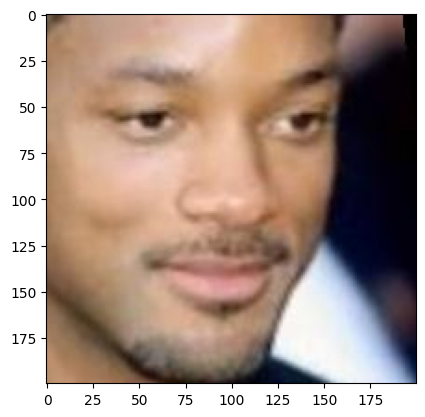

In [13]:
# Load and display an example image
img = Image.open(path / df.image[150])
plt.imshow(img)


C:\Users\Tejaswini\AppData\Local\Temp\ipykernel_21036\2886575943.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

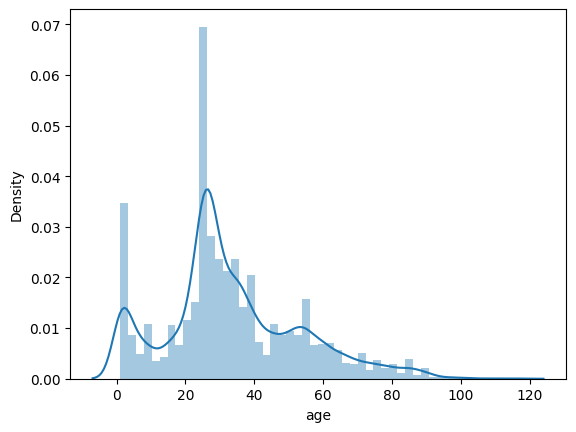

In [14]:
# Plot distributional graph for age
sns.distplot(df.age)


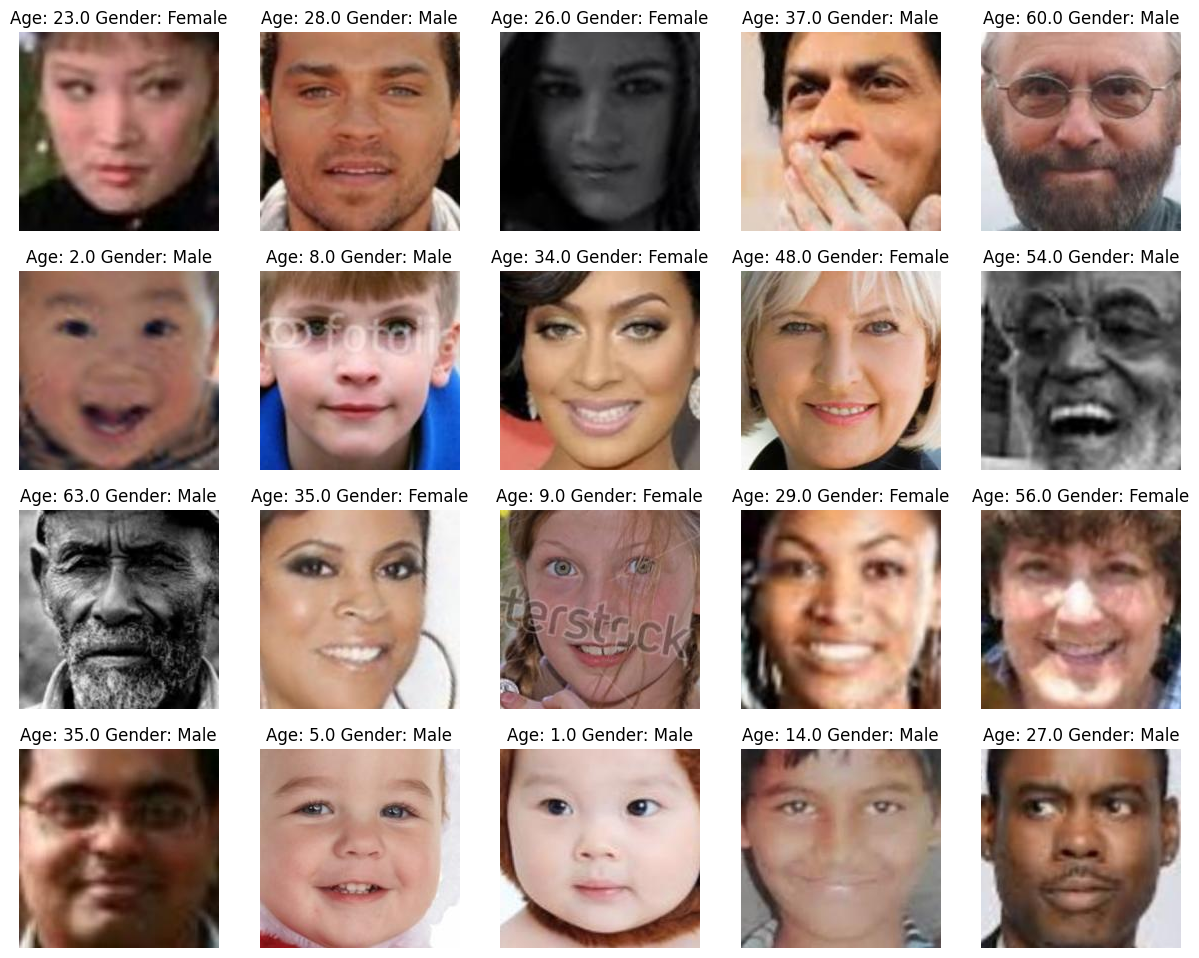

In [15]:
# Display some example images with age and gender labels
files = df.iloc[0:20]
plt.figure(figsize=(15, 15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(path / file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


In [16]:
# Train-test split
train, test = train_test_split(df, test_size=0.80, random_state=42)


In [17]:
# Prepare training data
x_train = []
for file in train.image:
    img = load_img(path / file, color_mode='grayscale')
    img = img.resize((128, 128))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train) 
x_train = x_train.reshape(len(x_train), 128, 128, 1)
x_train = x_train / 255

# Prepare labels
y_gender = np.array(train.gender)
y_age = np.array(train.age)


In [18]:
# Define model architecture
input_shape = (128, 128, 1)
inputs = Input(shape=input_shape)
X = Conv2D(64, (3, 3), activation='relu')(inputs)
X = MaxPooling2D((2, 2))(X)
X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)
X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)
X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.5)(X)

# Output layers
output_gender = Dense(1, activation='sigmoid', name='gender_output')(X)
output_age = Dense(1, activation='linear', name='age_output')(X)


In [19]:
# Compile the model
model = Model(inputs=inputs, outputs=[output_gender, output_age])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])


In [20]:
# Train the model
model_history = model.fit(x_train, [y_gender, y_age], batch_size=32, epochs=50, validation_split=0.1)


Epoch 1/50


134/134 [==============================] - 70s 508ms/step - loss: 18.2881 - gender_output_loss: 1.0648 - age_output_loss: 17.2233 - gender_output_accuracy: 0.5218 - age_output_accuracy: 0.0485 - val_loss: 16.3305 - val_gender_output_loss: 0.6804 - val_age_output_loss: 15.6500 - val_gender_output_accuracy: 0.5474 - val_age_output_accuracy: 0.0632
Epoch 2/50
134/134 [==============================] - 80s 594ms/step - loss: 16.1871 - gender_output_loss: 0.8032 - age_output_loss: 15.3839 - gender_output_accuracy: 0.5373 - age_output_accuracy: 0.0488 - val_loss: 14.7003 - val_gender_output_loss: 0.6488 - val_age_output_loss: 14.0515 - val_gender_output_accuracy: 0.6926 - val_age_output_accuracy: 0.0632
Epoch 3/50
134/134 [==============================] - 81s 608ms/step - loss: 13.6890 - gender_output_loss: 0.6465 - age_output_loss: 13.0425 - gender_output_accuracy: 0.6859 - age_output_accuracy: 0.0466 - val_loss: 13.0811 - val_gender_output_loss: 0.4941 - val_age_output_loss: 

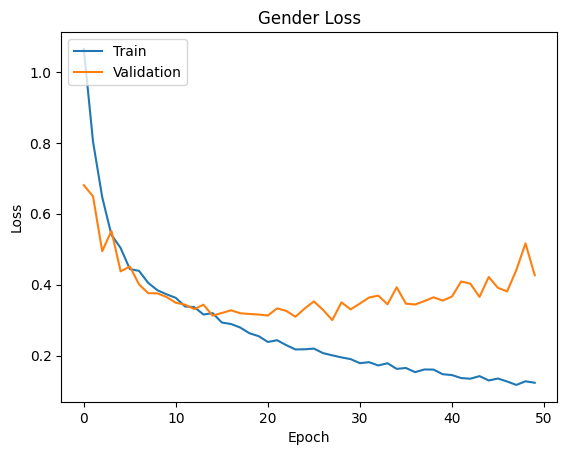

In [21]:
# Plot loss and accuracy for gender
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

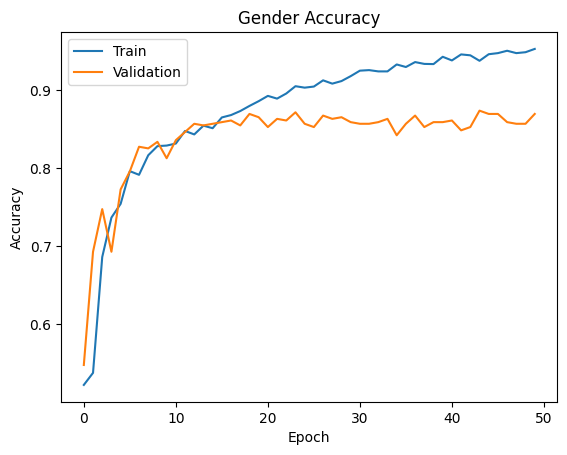

In [22]:
plt.plot(model_history.history['gender_output_accuracy'])
plt.plot(model_history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

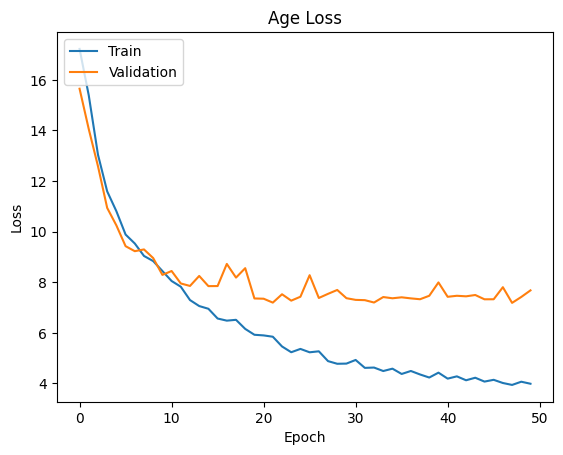

In [23]:
# Plot loss and accuracy for age
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

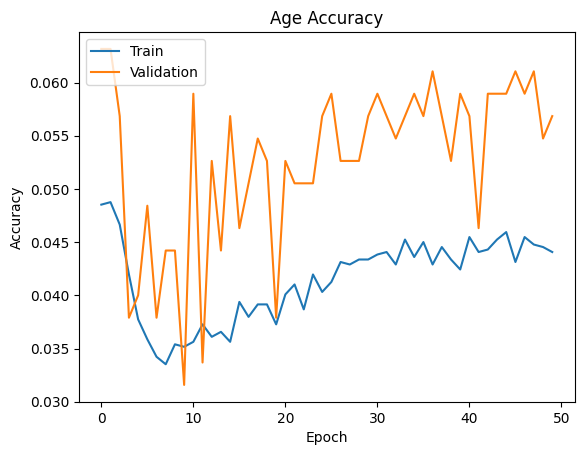

In [24]:
plt.plot(model_history.history['age_output_accuracy'])
plt.plot(model_history.history['val_age_output_accuracy'])
plt.title('Age Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
model.save("model.h5")

C:\Users\Tejaswini\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
